# Get sen2 DF

In [1]:
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import glob
import time
from rasterio.merge import merge
from rasterio.plot import show
import rasterio.features
import rasterio.warp
from geojson import Point, Feature, FeatureCollection, dump
import shapely.wkt
import matplotlib.pyplot as plt

In [2]:
root_dir = !pwd
root_dir = str(root_dir[0])
folder = "/sen2/merged_reprojected"
files_folder = root_dir + folder


In [3]:

# define search criteria
search_criteria = "*.tif"
search_term = os.path.join(files_folder, search_criteria)
# perform search


In [4]:
# create DF and uniwe
files = glob.glob(search_term)
dates = []
tiles = []
for i in files:
    dates.append(i[78:86])
    tiles.append(i[102:108])
df_sen2 = pd.DataFrame(np.column_stack([files, dates,tiles]),columns=["files","dates","tiles"])
unique_dates = pd.unique(df_sen2["dates"])

In [5]:
df_sen2

,files,dates,tiles
0,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180419,T30UXU
1,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180709,T30TVT
2,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180709,T30UVV
3,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180623,T30UXU
4,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180803,T30TVT
...,...,...,...
121,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180902,T30UUU
122,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180927,T30TWT
123,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180420,T30UVV
124,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180714,T30UWU


In [6]:
names = []
geoms = []
out_fp = root_dir + "footprints"


# Extract Footprints
counter = 0
for i in df_sen2["files"]:
    # def counter cond
    counter = counter+1
    if counter%1==0:
        perc = 100 * float(counter)/float(len(df_sen2["files"]))
        print(str(int(perc))+"%","       ",end="\r")
    
    
    file_name = i[i.rfind("/")+1:i.rfind(".")]
    #print(file_name)
    out_name = out_fp + file_name+".GeoJSON"
    #print(out_name)
    
    with rasterio.open(i) as dataset:

        # Read the dataset's valid data mask as a ndarray.
        mask = dataset.dataset_mask()

        # Extract feature shapes and values from the array.
        for geom, val in rasterio.features.shapes(
                mask, transform=dataset.transform):

            # Transform shapes from the dataset's own coordinate
            # reference system to CRS84 (EPSG:4326).
            #geom = rasterio.warp.transform_geom(
            #    dataset.crs, 'EPSG:4326', geom, precision=6)

            # Print GeoJSON shapes to stdout.
            n = out_name[out_name.rfind("/")+1:out_name.rfind(".")] + ".jp2"
            n = n.replace("footprints","")
            names.append(n)
            geoms.append(geom)
print(str(100)+"%","       ",end="\r")

In [7]:
# Modify WKT to be able to pass into GDF
wkt_geoms = []
for v,i in enumerate(geoms):
    coordinates = i["coordinates"]
    wkt_str = "POLYGON (("
    for coor in coordinates:
        for x in coor:
            wkt_str=wkt_str+""
            x_1 = str(x).replace(",","")
            x_1 = x_1.replace("(","")
            x_1 = x_1.replace(")","")
            #x_1 = x_1.replace(".0","")
            wkt_str = wkt_str+x_1+","
        wkt_str = wkt_str[:wkt_str.rfind(",")] + wkt_str[wkt_str.rfind(",")+1:]
            
    wkt_str = wkt_str.replace("[","")
    wkt_str = wkt_str.replace("]","")
    wkt_str = wkt_str+"))"
    #print(wkt_str)
    wkt_geoms.append(shapely.wkt.loads(wkt_str))

df_sen2["geom"] = wkt_geoms
gdf_sen2 = gpd.GeoDataFrame(df_sen2, geometry=df_sen2.geom)
gdf_sen2.set_crs(epsg=2154)

,files,dates,tiles,geom,geometry
0,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180419,T30UXU,"POLYGON ((350647.0106609548 6859450.010744817,...","POLYGON ((350647.011 6859450.011, 350647.011 6..."
1,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180709,T30TVT,"POLYGON ((143692.6836516875 6774980.536423556,...","POLYGON ((143692.684 6774980.536, 143692.684 6..."
2,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180709,T30UVV,"POLYGON ((158798.9263208066 6974419.573005313,...","POLYGON ((158798.926 6974419.573, 158798.926 6..."
3,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180623,T30UXU,"POLYGON ((350647.0106609548 6859450.010744817,...","POLYGON ((350647.011 6859450.011, 350647.011 6..."
4,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180803,T30TVT,"POLYGON ((143692.6836516875 6774980.536423556,...","POLYGON ((143692.684 6774980.536, 143692.684 6..."
...,...,...,...,...,...
121,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180902,T30UUU,"POLYGON ((51639.68855335622 6882132.811613104,...","POLYGON ((51639.689 6882132.812, 51639.689 676..."
122,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180927,T30TWT,"POLYGON ((243367.3657216941 6767408.600556872,...","POLYGON ((243367.366 6767408.601, 243367.366 6..."
123,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180420,T30UVV,"POLYGON ((158798.9263208066 6974419.573005313,...","POLYGON ((158798.926 6974419.573, 158798.926 6..."
124,/home/simon/CDE_UBS/thesis/data_collection/sen...,20180714,T30UWU,"POLYGON ((250952.2064251588 6867075.183695725,...","POLYGON ((250952.206 6867075.184, 250952.206 6..."


<AxesSubplot:>

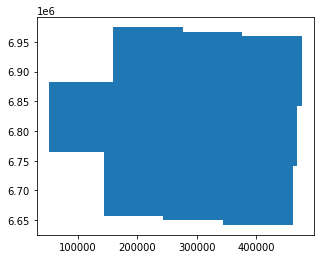

In [8]:
gdf_sen2.plot()

# Get Spot6 DF
## Get Spot6 Footprints

In [9]:
# define inputs
sensor = "spot6"
root_dir = "/home/simon/CDE_UBS/thesis/data_collection/"
out_fp = root_dir + "footprints"
path = root_dir + sensor



# define search criteria automatically based on sensor
if sensor == "spot6":
    search_criteria = "*.jp2"
if sensor == "sen2":
    search_criteria = "*.tif"
search_term = os.path.join(path, search_criteria)
# perform search
files = glob.glob(search_term)


In [10]:
names = []
geoms = []

# Extract Footprints
counter = 0
for i in files:
    # def counter cond
    counter = counter+1
    if counter%1==0:
        perc = 100 * float(counter)/float(len(files))
        print(str(int(perc))+"%","       ",end="\r")
    
    
    file_name = i[i.rfind("/")+1:i.rfind(".")]
    #print(file_name)
    out_name = out_fp + file_name+".GeoJSON"
    #print(out_name)
    
    with rasterio.open(i) as dataset:

        # Read the dataset's valid data mask as a ndarray.
        mask = dataset.dataset_mask()

        # Extract feature shapes and values from the array.
        for geom, val in rasterio.features.shapes(
                mask, transform=dataset.transform):

            # Transform shapes from the dataset's own coordinate
            # reference system to CRS84 (EPSG:4326).
            #geom = rasterio.warp.transform_geom(
            #    dataset.crs, 'EPSG:4326', geom, precision=6)

            # Print GeoJSON shapes to stdout.
            n = out_name[out_name.rfind("/")+1:out_name.rfind(".")] + ".jp2"
            n = n.replace("footprints","")
            names.append(n)
            geoms.append(geom)
print(str(100)+"%","       ",end="\r")

RasterioIOError: '/home/simon/CDE_UBS/thesis/data_collection/spot6/ORT_2018_0261_6813_LA93_8Bits.jp2' not recognized as a supported file format.

In [ ]:
# Modify WKT to be able to pass into GDF
wkt_geoms = []
for v,i in enumerate(geoms):
    coordinates = i["coordinates"]
    wkt_str = "POLYGON (("
    for coor in coordinates:
        for x in coor:
            wkt_str=wkt_str+""
            x_1 = str(x).replace(",","")
            x_1 = x_1.replace("(","")
            x_1 = x_1.replace(")","")
            #x_1 = x_1.replace(".0","")
            wkt_str = wkt_str+x_1+","
            #print(wkt_str)
        wkt_str = wkt_str[:wkt_str.rfind(",")] + wkt_str[wkt_str.rfind(",")+1:]
            
    wkt_str = wkt_str.replace("[","")
    wkt_str = wkt_str.replace("]","")
    wkt_str = wkt_str+"))"
    #print(wkt_str)
    wkt_geoms.append(shapely.wkt.loads(wkt_str))

df_spot6 = pd.DataFrame()
df_spot6["name"] = names
df_spot6["geom"] = wkt_geoms
gdf_spot6 = gpd.GeoDataFrame(df_spot6, geometry=df_spot6.geom)
gdf_spot6.set_crs(epsg=2154)

In [ ]:
gdf_spot6.plot()

## Get Centroids

In [ ]:
def get_centroid(gdf):
    a = gpd.GeoSeries(gdf.centroid)
    return(list(a))

In [ ]:
gdf_spot6["centroid"] = get_centroid(gdf_spot6)
gdf_sen2["centroid"] = get_centroid(gdf_sen2)

## Get Spot6 positions in sen2 tiles

In [ ]:
# convert geometryx to centroid
gdf_spot6.set_geometry("centroid",inplace=True)
gdf_spot6.plot(markersize=0.1)

In [ ]:
join_spot6_sen2 = gdf_spot6.sjoin(gdf_sen2, how="inner")

In [ ]:
join_spot6_sen2.head()

In [ ]:
join_spot6_sen2 = gpd.GeoDataFrame(join_spot6_sen2, geometry="centroid_left")
join_spot6_sen2.set_crs(epsg=2154,inplace=True)

In [ ]:
join_spot6_sen2.plot(markersize=0.1)

## Get Spot6 Dates

In [ ]:
# Load gdf of date info

In [ ]:
path = "/home/simon/CDE_UBS/thesis/data_collection/footprints/other/"
dates_spot6 = gpd.read_file(path+"FRANCE_2018_LA93_INFO.shp")

In [ ]:
# keep only dare and geometry column
dates_spot6 = dates_spot6[["DATE","geometry"]]
dates_spot6.set_crs(epsg=2154)
dates_spot6.plot()

In [ ]:
dates_spot6.head(1)

## Join Sen2/Spot6 Dates & Tiles with Spot6 aq. dates

In [ ]:
# rop previous remenants
join_spot6_sen2.drop('index_right', inplace=True, axis=1)

In [ ]:
# perform inner join and clean up df
join_spot6_sen2_DATES = join_spot6_sen2.sjoin(dates_spot6, how="inner")
join_spot6_sen2_DATES.drop(["geom_right","centroid_right","index_right"], inplace=True, axis=1)

In [ ]:
join_spot6_sen2_DATES.plot(markersize=0.1)

In [ ]:
# transform back to geometry of footprint
join_spot6_sen2_DATES = gpd.GeoDataFrame(join_spot6_sen2_DATES, geometry="geometry")
join_spot6_sen2_DATES.set_crs(epsg=2154,inplace=True)

In [ ]:
join_spot6_sen2_DATES.plot()

# Find closest date

## Transform dates to proper format

In [ ]:
import time
from datetime import datetime

In [ ]:
ls_sen2_date = []
ls_spot6_date = []
for date_s2,date_s6 in zip(join_spot6_sen2_DATES["dates"],join_spot6_sen2_DATES["DATE"]):
    ls_sen2_date.append(datetime.strptime(date_s2, "%Y%m%d"))
    ls_spot6_date.append(datetime.strptime(date_s6, "%Y%m%d"))
join_spot6_sen2_DATES["date_sen2"] = ls_sen2_date
join_spot6_sen2_DATES["date_spot6"] = ls_spot6_date
    

In [ ]:
join_spot6_sen2_DATES.head(2)

## Perform check for closest date

In [ ]:
spot6_unique = join_spot6_sen2_DATES["name"].unique()
sen2_tiles_unique = join_spot6_sen2_DATES["tiles"].unique()

In [ ]:
days_dif = []
days_dif_max = []
spot6_files = []
sen2_dates = []
unique_tile = []
other_acq = []

for spot6_image in spot6_unique:
    tmp = join_spot6_sen2_DATES[join_spot6_sen2_DATES["name"] == spot6_image]
    
    # extract dates for this specific Spot6 Aquisition
    spot6_file = 0
    spot6_date = list(tmp["date_spot6"])[0]
    sen2_dates = list(tmp["date_sen2"])
    
    # get sen2 file names and clean
    sen2_files = list(tmp["files"])
    for v,i in enumerate(sen2_files):
        sen2_files[v] = i[i.rfind("/")+1:]

    # Compare for closest point in time
    min_dif = 999999
    max_dif = 0
    s2_min_date = 0
    for s2_date in sen2_dates:
        dif = abs((spot6_date-s2_date).days)
        
        if max_dif<dif:
            max_dif = dif
        
        if min_dif>dif:
            min_dif=dif
            s2_min_date = s2_date
    
    # append dict of next closest sen2 aq. dates
    dates_dict = {}
    for s2_date,s2_file in zip(sen2_dates,sen2_files):
        dif = abs((spot6_date-s2_date).days)
        dates_dict[dif] = [s2_date,s2_file]
    other_acq.append(dates_dict)
            
    days_dif.append(min_dif)
    days_dif_max.append(max_dif)
    sen2_dates.append(s2_min_date)
    unique_tile.append(spot6_image)

### Test to build indepentent gdf (works!)

In [ ]:
df_new = pd.DataFrame(list(zip(unique_tile, days_dif,days_dif_max,other_acq)),columns =['name', 'min','max','other_acq'])
df_new = gpd.GeoDataFrame(df_new)

# 2
df_extract = pd.DataFrame(list(zip(gdf_spot6["name"],gdf_spot6["geom"])),columns =['name', 'geom'])
df_extract = gpd.GeoDataFrame(df_extract, geometry="geom")
df_extract.set_crs(epsg=2154,inplace=True)


In [ ]:
df_new = df_new.merge(df_extract,on="name", how="inner")
df_new = gpd.GeoDataFrame(df_new)
df_new = gpd.GeoDataFrame(df_new, geometry="geom")
df_new.set_crs(epsg=2154,inplace=True)

In [ ]:
df_new.plot(column='min')
df_new.plot(column='max')
plt.show()

In [ ]:
#df_new.to_file("/home/simon/CDE_UBS/thesis/data_collection/sen2/"+"closest_dates.geojson", driver="GeoJSON")
#df_new.to_file("closest_dates.gpkg", driver="GPKG")
df_new.to_pickle("/home/simon/CDE_UBS/thesis/data_collection/sen2/closest_dates.pkl")

In [ ]:
df_new

In [ ]:
pwd

In [ ]:
df_new